# Predicting the publisher's name from an article: A case study

In this notebook, you will be building a machine learning model for predicting the publisher's name from an article using various Google Cloud technologies.

But before you proceed,the problem statement needs to have a bit more reality to it:

> Imagine being the moderator of an online news forum and you're responsible for determining the source (publisher) of the news article. Doing this manually can be a very tedious task as you'll have to read the news articles and then derive the source. So, what if you could automate this task? So, at a very diluted level the problem statement becomes can I predict the publisher's name from a given article?

The problem can now be modeled as a text classification problem. In the rest of the article, you will be building a machine learning model to solve this. The summary of the steps looks like so:
* Gather data
* Preprocess the dataset
* Get the data ready for feeding to a sequence model
* Build, train and evaluate the model

## System setup

You will be using Google Cloud Platform (GCP) as the infrastructure. It's easy to configure a system I would need for this project starting from the data to the libraries for building the model(s). 
You will start off by spinning off a Jupyter Lab instance which comes as a part of GCP's AI Platform. To be able to spin off a Jupyter Lab instance on GCP's AI Platform, you will need a [billing-enabled GCP Project](https://cloud.google.com/bigquery/docs/visualize-jupyter#beforeyoubegin). One can navigate to the Notebooks section on the AI Platform very easily:

![](https://i.ibb.co/rby8yPD/Screenshot-from-2019-07-29-20-23-24.png)

After clicking on the Notebooks, a dashboard like the following lands up:

![](https://i.ibb.co/55BxghD/Screenshot-from-2019-07-29-20-25-02.png)

You will be using `TensorFlow 2.0` for this project, so choose accordingly:

![](https://i.ibb.co/m62CNsq/Screenshot-from-2019-07-29-20-26-00.png)

After clicking on *With 1 NVIDIA Tesla K80*, you will be shown a basic configuration window. Keep it default, just tick off the GPU driver installation box and then click on CREATE.

![](https://i.ibb.co/GQWdyrz/Screenshot-from-2019-07-29-20-26-55.png)

It will take some time to get the instance (~ 5 minutes). You just need to click on *OPEN JUPYTERLAB* to access the notebook instance after the instance is ready.

![](https://i.ibb.co/dfqhqZT/Screenshot-from-2019-07-29-20-28-17.png)

You will also be using [BigQuery](https://cloud.google.com/bigquery/) in this project and that too via the notebooks. So, as soon as I=you get the notebook instance, open up a terminal to install the BigQuery notebook extension:

```
pip3 install --upgrade google-cloud-bigquery
```


That's it for system setup part.

> BigQuery is a serverless, highly-scalable, and cost-effective cloud data warehouse with an in-memory BI Engine and [machine learning](https://cloud.google.com/bigquery/#bigqueryml) built-in.

## Where do I get the data?

It may not always be the case that the data will be readily available for the problem you're trying to solve. Fortunately, in this case, there is already a dataset which is good enough to start with.

The dataset you are going to use is already available as a BigQuery public dataset ([link](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=hacker_news&page=dataset)). But the dataset needs to be shaped a bit aligning to with respect to the problem statement. You'll come to this later. 

This dataset contains all stories and comments from **Hacker News** from its launch in 2006 to present. Each story contains a story ID, the author that made the post, when it was written, and the number of points the story received.

To get the data right in my notebook instance, you'll need to configure the GCP Project within the notebook's environment:

In [3]:
# Set your Project ID
import os
PROJECT = 'your-project-name'
os.environ['PROJECT'] = PROJECT

Replace `you-project-name` with the name of your GCP project. You are now ready to run a query which would access the BigQuery dataset:

In [4]:
%%bigquery --project $PROJECT data_preview
SELECT
  url, title, score
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  LENGTH(title) > 10
  AND score > 10
  AND LENGTH(url) > 0
LIMIT 10

Let's break down a few things here:

- `%%bigquery --project $PROJECT data_preview`: `%%bigquery` is a [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) which lets you run SQL like queries (compatible for BigQuery) from your notebook. `--project $PROJECT` is used to guide BigQuery which GCP Project you're using. `data_preview` is the name of the Pandas DataFrame to which you're going to save results of the query (isn't this very useful?). 
- `hacker_news` is the name of the BigQuey public dataset and stories is the name of the table residing inside it. 
- Three columns only: `url` of the article, `title` of the article and `score` of the article. You'll be using the article titles to determine their sources.

You chose to include only those entries where the length of the article title and article's corresponding URL is greater than 10. The query returned 402 MB of data. 

Here are the first five rows from the DataFrame data_preview:

![](https://i.ibb.co/Zg5bG14/Screenshot-from-2019-07-30-08-15-08.png)

The data collection part is now done for the project. At this stage, I was good to proceed to the next steps: cleaning and preprocessing!

## Beginning data wrangling

The problem in the current data is in place of `url` I need the source of the URL. For example, `https://github.com/Groundworkstech/Submicron` should appear as `github`. I would also want to rename the `url` column to source. But before doing that, I figured out the distribution in the titles belonging to several sources.

In [7]:
%%bigquery --project $PROJECT source_num_articles
SELECT
  ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
  COUNT(title) AS num_articles
FROM
  `bigquery-public-data.hacker_news.stories`
WHERE
  REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
  AND LENGTH(title) > 10
GROUP BY
  source
ORDER BY num_articles DESC

Preview the `source_num_articles` DataFrame:

In [8]:
source_num_articles.head()

,source,num_articles
0,blogspot,41386
1,github,36525
2,techcrunch,30891
3,youtube,30848
4,nytimes,28787


BigQuery provides a number of functions like `ARRAY_REVERSE()`, `REGEXP_EXTRACT()` and so on for useful tasks. With the above query, I first split the URLs with respect to // and / and then I extracted the domains from the URLs.

But the project needs different data - a dataset which will contain the articles along with their sources. The stories table contains a lot of article sources other than the ones shown above. So, to keep it a bit more light-weighted, let's go with these five ones: blogpost, github, techcrunch, youtube and nytimes.

In [9]:
%%bigquery --project $PROJECT full_data
SELECT source, LOWER(REGEXP_REPLACE(title, '[^a-zA-Z0-9 $.-]', ' ')) AS title FROM
  (SELECT
    ARRAY_REVERSE(SPLIT(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.'))[OFFSET(1)] AS source,
    title
  FROM
    `bigquery-public-data.hacker_news.stories`
  WHERE
    REGEXP_CONTAINS(REGEXP_EXTRACT(url, '.*://(.[^/]+)/'), '.com$')
    AND LENGTH(title) > 10
  )
WHERE (source = 'github' OR source = 'nytimes' OR 
       source = 'techcrunch' or source = 'blogspot' OR
       source = 'youtube')

Previewing the `full_data` DataFrame, you get:

In [10]:
full_data.head()

,source,title
0,github,feminist-software-foundation complains about r...
1,github,expose sps as web services on the fly.
2,github,show hn scrwl shorthand code reading and wr...
3,github,geoip module on nodejs now is a c addon
4,github,show hn linuxexplorer


Data understanding is vital for machine learning modeling to work well and to be understood. Let's take some time out and perform some basic EDA. 

## Data understanding

You will start the process of EDA by investigating the dimensions of the dataset. In this case, the dataset prepared in the above step had 168437 rows including 2 columns as can be seen in the preview. 

Following is the class distribution of the articles:

![](https://i.ibb.co/phyx9SQ/Screenshot-from-2019-07-30-08-25-05.png)

Fortunately enough there is no missing values in the dataset and the following little tweedle can help you knowing that:

In [11]:
# Missing value inspection
full_data.isna().sum()

source    0
title     0
dtype: int64

A common question that arises while dealing with text data like this is - *how is the length of the titles distributed?*

Fortunately, Pandas provides a lot of useful functions to answer questions like this

In [12]:
full_data['title'].apply(len).describe()

count    168437.000000
mean         46.663174
std          17.080766
min          11.000000
25%          34.000000
50%          46.000000
75%          59.000000
max         138.000000
Name: title, dtype: float64

You have a minimum length of 11 and a maximum length of 138. I will come to this again in a moment. 

EDA is incomplete without plots! In this case, a very useful plot could be **Count vs. Title lengths**:

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


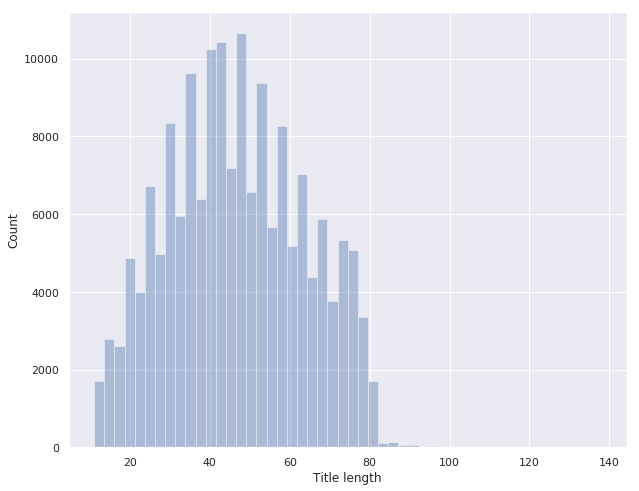

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

text_lens = full_data['title'].apply(len).values
plt.figure(figsize=(10,8))
sns.set()
g = sns.distplot(text_lens, kde=False, hist_kws={'rwidth':1})
g.set_xlabel('Title length')
g.set_ylabel('Count')
plt.show()

Almost bell, isn't it? From the plot, it is evident that the counts are skewed for title lengths < 20 and > 80. So, you may have to be careful in tackling them. Let's perform some manual inspections to figure out:
- how many titles fall above the minimum title length (11)?
- how many titles have the maximum length (138)?

Let's find out.

In [14]:
(text_lens <= 11).sum(), (text_lens == 138).sum()

(513, 1)

You should be getting 513 and 1 respectively. You will now remove the entry denoting the maximum article length from the dataset since it's just 1:

In [15]:
full_data = full_data[text_lens < 138].reset_index(drop=True)

The last thing you'll be doing in this step was splitting the dataset into train/validation/test sets in a ratio of 80:10:10.

In [16]:
# 80% for train
train = full_data.sample(frac=0.8)
full_data.drop(train.index, axis=0, inplace=True)

# 10% for validation
valid = full_data.sample(frac=0.5)
full_data.drop(valid.index, axis=0, inplace=True)

# 10% for test
test = full_data
train.shape, valid.shape, test.shape

((134749, 2), (16844, 2), (16843, 2))

The new data dimensions are: ((110070, 2), (13759, 2), (13759, 2)). Just to be a little more certain on the class distribution, you will now verify that across the three sets:

![](https://i.ibb.co/m9z91rJ/Screenshot-from-2019-07-30-08-33-40.png)

The distributions are relatively same across the three sets. Let's serialize these three sets to Pandas DataFrames.

In [ ]:
train.to_csv('data/train.csv', index=False)
valid.to_csv('data/valid.csv', index-False)
test.to_csv('data/test.csv', index=False)

There's still some amount of data preprocessing need - as computers only understand numbers, you'll to prepare the data accordingly to stream to the machine learning model:

- Encoding the classes to some numbers (label encoding/one-hot encoding)
- Creating a vocabulary from the training corpus - tokenization
- Numericalizing the titles and pad them to a fixed-length
- Preparing the embedding matrix with respect to pre-trained embeddings like [GloVe](https://nlp.stanford.edu/projects/glove/).

Let's proceed accordingly.

## Additional data preprocessing

First, you'll define the constants that would be necessary here:

In [18]:
# Label encode
CLASSES = {'blogspot': 0, 'github': 1, 'techcrunch': 2, 'nytimes': 3, 'youtube': 4} 
# Maximum vocabulary size used for tokenization
TOP_K = 20000 
# Sentences will be truncated/padded to this length
MAX_SEQUENCE_LENGTH = 50

Now, you'll define a tiny helper function which would take a Pandas DataFrame and would
- prepare a list of titles from the DataFrame (needed for further preprocessing)
- take the sources from the DataFrame, map them to integers and append to a NumPy array

In [19]:
def return_data(df):
    return list(df['title']), np.array(df['source'].map(CLASSES))

# Apply it to the three splits
train_text, train_labels = return_data(train)
valid_text, valid_labels = return_data(valid)
test_text, test_labels = return_data(test)

print(train_text[0], train_labels[0])

the davos question. what one thing must be done to make the world a better place in 2008  4


The result is as expected. 

You'll use the `text` and `sequence` modules provided by `tensorflow.keras.preprocessing` to tokenize and pad the titles. You'll start with tokenization:

In [21]:
# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D

In [22]:
# Create a vocabulary from training corpus
tokenizer = text.Tokenizer(num_words=TOP_K)
tokenizer.fit_on_texts(train_text)

You'll be using the *GloVe* embeddings to represent the words in the titles to a dense representation. The embeddings' file is of more than 650 MB and the GCP team has it stored in a [Google Storage Bucket](https://cloud.google.com/storage/docs/json_api/v1/buckets). This was incredibly helpful since it would allow you to directly use it in the notebook at a very fast speed. You'lle be using the `gsutil` command (available in the Notebooks) to aid this.

```
!gsutil cp gs://cloud-training-demos/courses/machine_learning/deepdive/09_sequence/text_classification/glove.6B.200d.txt glove.6B.200d.txt
```

You would need a helper function which would map the words in the titles with respect to the Glove embeddings.

In [25]:
def get_embedding_matrix(word_index, embedding_path, embedding_dim):
    embedding_matrix_all = {}
    with open(embedding_path) as f:
        for line in f:  # Every line contains word followed by the vector value
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix_all[word] = coefs
# Prepare embedding matrix with just the words in our word_index dictionary
    num_words = min(len(word_index) + 1, TOP_K)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= TOP_K:
            continue
        embedding_vector = embedding_matrix_all.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
  
    return embedding_matrix

This is all you will need to stream the text data to the yet-to-be-built machine learning model.

## Building the Horcrux: A sequential language model

Let's specify a couple of hyperparameter values towards the very beginning of the modeling process.

In [26]:
# Specify the hyperparameters
filters=64
dropout_rate=0.2
embedding_dim=200
kernel_size=3
pool_size=3
word_index=tokenizer.word_index
embedding_path = 'glove.6B.200d.txt'
embedding_dim=200

You'll be using a Convolutional Neural Network based model which would basically start by convolving on the embeddings fed to it. Locality is important in sequential data and CNNs would allow me to capture that effectively. The trick is to do all the fundamental CNN operations (convolution, pooling) in 1D.

You'll be following the typical Keras paradigm - you'll first instantiate the model, then will define the topology and then compile the model accordingly.

In [ ]:
# Create model instance
model = models.Sequential()
num_features = min(len(word_index) + 1, TOP_K)
# Add embedding layer - GloVe embeddings
model.add(Embedding(input_dim=num_features,
              output_dim=embedding_dim,
              input_length=MAX_SEQUENCE_LENGTH,
              weights=[get_embedding_matrix(word_index, 
                              embedding_path, embedding_dim)],
              trainable=True))
model.add(Dropout(rate=dropout_rate))
model.add(Conv1D(filters=filters,
              kernel_size=kernel_size,
              activation='relu',
              bias_initializer='he_normal',
              padding='same'))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(filters=filters * 2,
              kernel_size=kernel_size,
              activation='relu',
              bias_initializer='he_normal',
              padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(rate=dropout_rate))
model.add(Dense(len(CLASSES), activation='softmax'))
# Compile model with learning parameters.
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

The architecture looks like so:

![](https://i.ibb.co/rt5Cxgd/cnn-txt-cls.png)

One more step that was remaining at this point was Numericalizing the titles and pad them to a fixed-length.

In [ ]:
# Preprocess the train, validation and test sets
# Tokenize and pad sentences
preproc_train = tokenizer.texts_to_sequences(train_text)
preproc_train = sequence.pad_sequences(preproc_train, maxlen=MAX_SEQUENCE_LENGTH)

preproc_valid = tokenizer.texts_to_sequences(valid_text)
preproc_valid = sequence.pad_sequences(preproc_valid, maxlen=MAX_SEQUENCE_LENGTH)

preproc_test = tokenizer.texts_to_sequences(test_text)
preproc_test = sequence.pad_sequences(preproc_test, maxlen=MAX_SEQUENCE_LENGTH)

And finally, you're prepared to kickstart the training process!

In [ ]:
H = model.fit(preproc_train,
         train_labels,
         validation_data=(preproc_valid, valid_labels),
         batch_size=128,
         epochs=10,
         verbose=1)

Here's a snap of the training log:

![](https://i.ibb.co/rb2pWHR/Screenshot-from-2019-07-30-09-01-57.png)

The network does overfit and the training graph also confirms it:

![](https://i.ibb.co/rdY4c4b/training-history.png)

Overall, the model yields an accuracy of ~66% which is not upto the mark given the developments of the hour. But it is a good start. Let's now write a little function to use the network to predict the on individual samples:

In [ ]:
# Helper function to test on single samples
def test_on_single_sample(text):
    category = None
    text_tokenized = tokenizer.texts_to_sequences(text)
    text_tokenized = sequence.pad_sequences(text_tokenized,maxlen=50)
    prediction = int(model.predict_classes(text_tokenized))
    for key, value in CLASSES.items():
    if value==prediction:
        category=key
  
  return category

Prepare the samples accordingly:

In [27]:
# Prepare the samples
github=['Invaders game in 512 bytes']
nytimes = ['Michael Bloomberg Promises $500M to Help End Coal']
techcrunch = ['Facebook plans June 18th cryptocurrency debut']
blogspot = ['Android Security: A walk-through of SELinux']

Finally, test `test_on_single_sample()` on the above samples:

In [ ]:
for sample in [github, nytimes, techcrunch, blogspot]:
    print(test_on_single_sample(sample))

```
github
techcrunch
techcrunch
blogspot
```

That was it for this project. In the next section, you'll find my comments on the future directions for this project and then some references used for this project.

## Future directions and references

Just like in the computer vision domain, we expect models that understand the domain to be robust against certain transformations like rotation and translation, in the sequence domain, it's important then models be robust to changes in the length of the pattern. Keeping that in mind, here's a list of what I would try in the near future:
- Try other sequence models
- A bit of hyperparameter tuning
- Learn the embeddings from scratch
- Try different embeddings like universal sentence encoder, nnlm-128 and so on

After I have a decent model (with at least ~80% accuracy), I plan to serve the model as a REST API and deploy it on AppEngine.

Following are the references that were very useful for this project:
- [Guide on Text Classification](https://developers.google.com/machine-learning/guides/text-classification/) by Google
- [Deep Learning for Time Series Forecasting](https://machinelearningmastery.com/deep-learning-for-time-series-forecasting/) by Jason Brownlee (Machine Learning Mastery)
- [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by François Chollet
- [Sequence Models for Time Series and Natural Language Processing](https://www.coursera.org/learn/sequence-models-tensorflow-gcp/home/welcome), a course designed and developed by the Google Cloud team (offered via Coursera)

It's an end to the article here. I wrote this article to walk the readers through the approach I generally take for a machine learning problem. Of course, there's more to it but the steps I showed above are the most important ones for me. Thank you for taking the time to read the article and I will see you next time :)